## **Q2a**


## Importing Packages

In [25]:
import torch as pt
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,color
from math import exp
import scipy as sc
from scipy.sparse.linalg import eigsh
from skimage.color import rgba2rgb

In [14]:
weights = torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
model = torchvision.models.segmentation.fcn_resnet50(weights=weights)

# Transforming Data

In [15]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
model.eval()

In [17]:
# Colour Palette for PASCALVOC Dataset used
PASCAL_VOC_CLASSES_COLORS = {
    0: (0, 0, 0),        # Background
    1: (128, 0, 0),      # Aeroplane
    2: (0, 128, 0),      # Bicycle
    3: (128, 128, 0),    # Bird
    4: (0, 0, 128),      # Boat
    5: (128, 0, 128),    # Bottle
    6: (0, 128, 128),    # Bus
    7: (128, 128, 128),  # Car
    8: (64, 0, 0),       # Cat
    9: (192, 0, 0),      # Chair
    10: (64, 128, 0),    # Cow
    11: (192, 128, 0),   # Diningtable
    12: (64, 0, 128),    # Dog
    13: (192, 0, 128),   # Horse
    14: (64, 128, 128),  # Motorbike
    15: (192, 128, 128), # Person
    16: (0, 64, 0),      # Potted plant
    17: (128, 64, 0),    # Sheep
    18: (0, 192, 0),     # Sofa
    19: (128, 192, 0),   # Train
    20: (0, 64, 128)     # TV/Monitor
}

# Dataset

In [18]:
import os
with open("/content/drive/MyDrive/Colab Notebooks/AIP Assignments/test.txt") as file:
  valid_indices = [line.strip() for line in file]

folder = "/content/drive/MyDrive/Colab Notebooks/AIP Assignments/test/Images"
file_names = sorted(os.listdir(folder))
file_paths = [os.path.join(folder, file_name) for file_name in file_names]

filtered_file_paths = []
for file_path in file_paths:
    base_name, ext = os.path.splitext(os.path.basename(file_path))
    if base_name in valid_indices:
        filtered_file_paths.append(file_path)

image_files = [io.imread(image_path) for image_path in filtered_file_paths]


folder = "/content/drive/MyDrive/Colab Notebooks/AIP Assignments/test/Annotations"
annot_names = sorted(os.listdir(folder))
annot_paths = [os.path.join(folder, annot_name) for annot_name in annot_names]
annot_files = [io.imread(annot_path) for annot_path in annot_paths]


In [19]:
class SegmentationDataset(Dataset):
    def __init__(self, image_files, annotation_files, lookup_table, transform=None):
        self.image_files = image_files
        self.annotation_files = annotation_files
        self.lookup_table = lookup_table
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.image_files[idx]
        annotation = self.annotation_files[idx]
        annotation = annotation[:,:,:3]
        mask = np.zeros_like(annotation[:, :, 0])
        
        for label, color in self.lookup_table.items():
          m = np.all(annotation == color, axis=-1)
          mask[m] = label
        # for label, color in self.lookup_table.items():
        #     mask[np.where(annotation == color)] = label

        

        if self.transform:
            image = self.transform(image)
            #mask = self.transform(mask)

        return image, mask

# Data Loader

In [34]:
dataset = SegmentationDataset(image_files, annot_files, PASCAL_VOC_CLASSES_COLORS, preprocess)
data_loader = pt.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


In [21]:
def find_iou(pred, target, num_classes):   #defining function to evaluate IOU
    ious = []
    for class_id in range(num_classes):
        intersection = (pred == class_id) & (target == class_id)
        union = (pred == class_id) | (target == class_id)
        if union.sum()!=0:
          iou = intersection.sum() / union.sum()
          ious.append(iou)
    return np.mean(ious)

In [22]:
net_accs = []    #defining lists for storing accuracies and IOUs
net_iou = []
for i, (images, targets) in enumerate(data_loader):
  out_img=model(images)
  out_img=out_img['out'][0]
  out = out_img.argmax(0)
  out = out.numpy()
  targets = pt.squeeze(targets)
  ans = targets.numpy()
  acc = np.mean(out == ans)
  iou = find_iou(out,ans,21)
  net_accs.append(acc)
  net_iou.append(iou)


# Testing Model for an image

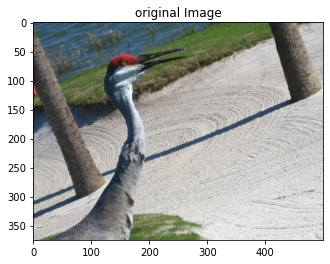

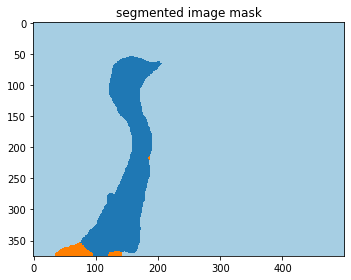

In [59]:
img = io.imread('/content/drive/MyDrive/Colab Notebooks/AIP Assignments/test/Annotations/000068.png')
img.shape
img = img[:,:,:3]
ground_truth_mask = np.zeros_like(img[:, :, 0])
ground_truth_mask.shape
for class_id, class_color in enumerate(PASCAL_VOC_CLASSES_COLORS.values()):
  mask = np.all(img == class_color, axis=-1)
  ground_truth_mask[mask] = class_id

ground_truth_mask.shape



img = io.imread('/content/drive/MyDrive/Colab Notebooks/AIP Assignments/test/Actual_Img/000068.jpg')  #Actual test Image
plt.title("original Image")
plt.imshow(img)
plt.show()
img = preprocess(img)
img = pt.unsqueeze(img, dim=0)
out_img =model(img)
out_img=out_img['out'][0]
out_img.shape
out = out_img.argmax(0)
out.shape
out = out.numpy()
colormap = plt.cm.get_cmap("Paired", 21)
colored_segmentation = colormap(out)
plt.title("segmented image mask")     #Printing Segmented Image Mask by Model
io.imshow(colored_segmentation)



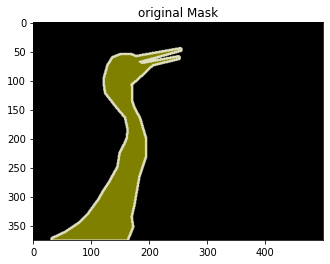

In [60]:
img = io.imread('/content/drive/MyDrive/Colab Notebooks/AIP Assignments/test/Annotations/000068.png')
plt.title("original Mask")     # Actual Segmentation Mask
plt.imshow(img)
plt.show()

In [46]:
np.mean(net_iou)

0.6400260908862386

In [47]:
np.mean(net_accs)

0.9163349391005375

# **Q2d**

## Importing Packages

In [48]:
import torch
import math
import torchvision
import numpy as np
import skimage.io
import skimage.transform
from skimage.transform import rotate
import skimage.io as io
from PIL import Image
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import skimage.io as io
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import os

# Checking for Computation Devies

In [49]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Importing ResNet50 FCN model from PyTorch

In [ ]:
#Importing ResNet50 FCN model from PyTorch  
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
model.eval()
model.to(device)

# original images

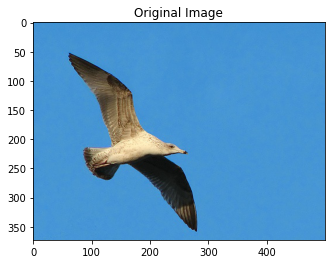

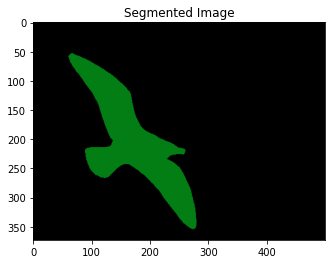

In [61]:
#TEST4.JPG
input_image = Image.open('/content/test4.jpg')
input_image = input_image.convert("RGB")
plt.title("Original Image")
plt.imshow(input_image)
plt.show()
#print(input_image.size)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
#print(input_tensor)
#print(torch.size(input_tensor))
input_batch = input_tensor.unsqueeze(0) 

# EXPORTING INPUT & model to GPU device
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# CLASS BASED COLOR SELECTION 
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 27 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# SEMANTIC SEGMENTATION BASED ON 21 CLASSES
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)
plt.title("Segmented Image")
plt.imshow(r)

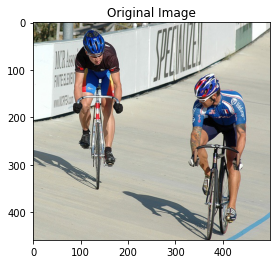

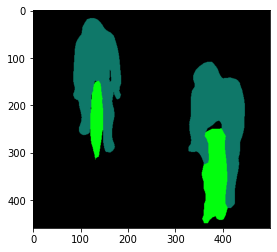

In [52]:
#TEST5.JPG
input_image = Image.open('/content/test5.jpg')
input_image = input_image.convert("RGB")
plt.title("Original Image")
plt.imshow(input_image)
plt.show()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

# EXPORTING INPUT & model to GPU device
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# CLASS BASED COLOR SELECTION 
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 27 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# SEMANTIC SEGMENTATION BASED ON 21 CLASSES
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)
plt.imshow(r)

# rotated images

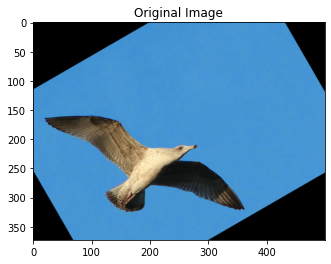

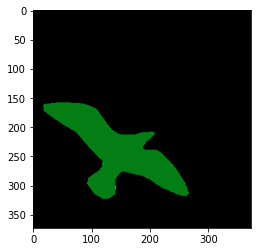

In [53]:
#ROTATED TEST4.JPG
input_image = io.imread('/content/test4.jpg')

input_image = skimage.transform.rotate(input_image,30)
plt.title("Original Image")
plt.imshow(input_image)
plt.show()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

# EXPORTING INPUT & model to GPU device
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch.float())['out'][0]
output_predictions = output.argmax(0)

# CLASS BASED COLOR SELECTION 
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 27 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# SEMANTIC SEGMENTATION BASED ON 21 CLASSES
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize((input_image.shape[0],input_image.shape[0]))
r.putpalette(colors)
plt.imshow(r)

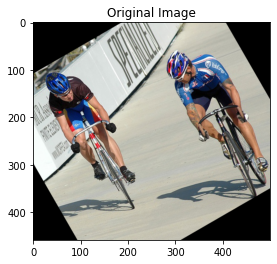

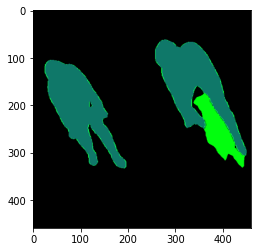

In [54]:
#ROTATED TEST5.JPG
input_image = io.imread('/content/test5.jpg')

input_image = skimage.transform.rotate(input_image,30)
plt.title("Original Image")
plt.imshow(input_image)
plt.show()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

# EXPORTING INPUT & model to GPU device
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch.float())['out'][0]
output_predictions = output.argmax(0)

# CLASS BASED COLOR SELECTION 
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 27 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# SEMANTIC SEGMENTATION BASED ON 21 CLASSES
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize((input_image.shape[0],input_image.shape[0]))
r.putpalette(colors)
plt.imshow(r)

# Noisy Images

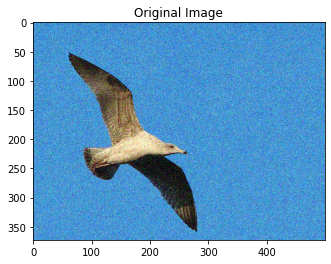

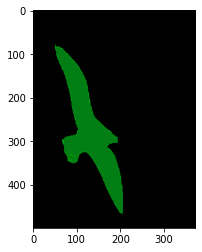

In [55]:
#NOISY IMAGE TEST4.JPG
input_image = io.imread('/content/test4.jpg')

input_image = skimage.util.random_noise(input_image, mode='gaussian')
plt.title("Original Image")
plt.imshow(input_image)
plt.show()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

# EXPORTING INPUT & model to GPU device
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch.float())['out'][0]
output_predictions = output.argmax(0)

# CLASS BASED COLOR SELECTION 
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 27 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# SEMANTIC SEGMENTATION BASED ON 21 CLASSES
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize((input_image.shape[0],input_image.shape[1]))
r.putpalette(colors)
plt.imshow(r)

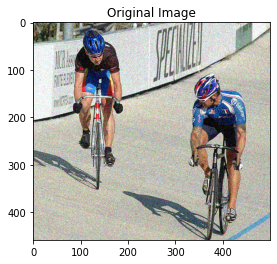

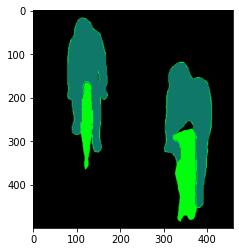

In [56]:
#NOISY IMAGE TEST5.JPG
input_image = io.imread('/content/test5.jpg')

input_image = skimage.util.random_noise(input_image, mode='gaussian')
plt.title("Original Image")
plt.imshow(input_image)
plt.show()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) 

# EXPORTING INPUT & model to GPU device
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch.float())['out'][0]
output_predictions = output.argmax(0)

# CLASS BASED COLOR SELECTION 
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 27 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# SEMANTIC SEGMENTATION BASED ON 21 CLASSES
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize((input_image.shape[0],input_image.shape[1]))
r.putpalette(colors)
plt.imshow(r)